In [1]:
%cd "~/pln-brca-xp/notebooks"
%load_ext autoreload
%autoreload 2

/home/xabush/pln-brca-xp/notebooks


In [2]:
import numpy as np

from utils import *
from utils_emb import *

In [3]:
st_df = pd.read_csv("/var/www/datasets/embedding_vector_state_and_outcome.csv", index_col="patient_ID")
ge_df = pd.read_csv("/var/www/datasets/merged-combat15.csv.xz", index_col="patient_ID")


In [4]:
tamoxifen_studies_v2 = ["GSE12093",  "GSE1379", "GSE17705", "GSE9893"]
st_tamx_df = st_df[st_df["series_id"].isin(tamoxifen_studies_v2)]
ge_out_df = ge_df.join(st_df["posOutcome"])
ge_tamx_df = ge_df.loc[st_tamx_df.index,:]
ge_out_tamx_df = ge_tamx_df.join(st_df["posOutcome"])
st_tamx_tr, st_tamx_te, y_st_tamx_tr, y_st_tamx_te = get_train_test_set(st_tamx_df, "/var/www/datasets/tamox_train_set.txt", "/var/www/datasets/tamox_test_set.txt")



In [5]:
X_tr, X_te, y_tr, y_te = get_train_test_set(ge_out_tamx_df, "/var/www/datasets/tamox_train_set.txt", "/var/www/datasets/tamox_test_set.txt")

In [6]:
gse9893_idx_tr, gse9893_idx_te = st_tamx_tr[st_tamx_tr["series_id"] == "GSE9893"].index, st_tamx_te[st_tamx_te["series_id"] == "GSE9893"].index

In [7]:
X_tr_9893, y_tr_9893 = ge_tamx_df.loc[gse9893_idx_tr], ge_out_tamx_df["posOutcome"].loc[gse9893_idx_tr]
X_te_9893, y_te_9893 = ge_tamx_df.loc[gse9893_idx_te], ge_out_tamx_df["posOutcome"].loc[gse9893_idx_te]
print(X_tr_9893.shape)
print(X_te_9893.shape)

(125, 8832)
(23, 8832)


In [21]:
import diffxpy.api as de
import anndata

data = anndata.AnnData(
    X=X_tr_9893.values,
    var=pd.DataFrame(index=X_tr_9893.columns.to_list()),
    obs=y_tr_9893.to_frame()
)
diff_expr = de.test.wald(
    data=data,
    formula_loc="~ 1 + posOutcome",
    factor_loc_totest="posOutcome"
)

training location model: False
training scale model: True
iter   0: ll=815885210.712257
iter   1: ll=815885210.712257, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=467906012.646998, converged: 56.49% (loc: 56.49%, scale update: True), in 16.64sec
iter   3: ll=467906012.646998, converged: 56.49% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=464880900.978849, converged: 70.71% (loc: 70.71%, scale update: True), in 7.82sec
iter   5: ll=464880900.978849, converged: 70.71% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=464804214.483935, converged: 88.27% (loc: 88.27%, scale update: True), in 5.45sec
iter   7: ll=464804214.483935, converged: 88.27% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=464781243.927192, converged: 96.71% (loc: 96.71%, scale update: True), in 2.89sec
iter   9: ll=464781243.927192, converged: 96.71% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=464775393.700098, converged: 99.28

In [23]:
diff_expr.summary().sort_values(by="pval")

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
1945,S100A2,0.000007,0.058480,0.432956,4.656689,False,7.109108e-01,0.432956,0.096095,-78.097122
4900,ESR1,0.000015,0.068210,-0.289571,7.406254,False,3.352407e-04,-0.289571,0.066996,-285.106185
2427,GRB14,0.000141,0.413785,0.357532,4.698453,False,3.318303e-01,0.357532,0.093910,-149.173645
7252,RARRES1,0.000356,0.786330,0.283114,6.367801,False,3.127573e-01,0.283114,0.079290,-22.473608
2102,TFF1,0.000598,0.913010,-0.226971,7.701874,False,8.725465e-15,-0.226971,0.066127,-93055.008990
...,...,...,...,...,...,...,...,...,...,...
4556,DDX17,0.999695,0.999968,0.000029,6.036323,False,7.751133e-15,0.000029,0.077074,-93055.008990
7963,SSTR3,0.999731,0.999968,-0.000035,3.424052,False,5.577723e-02,-0.000035,0.102334,-194.920362
4011,CARD8,0.999832,0.999968,0.000018,4.751930,False,2.202682e-15,0.000018,0.086868,-93055.008990
82,MRPS27,0.999934,0.999968,0.000006,6.959318,False,7.347012e-15,0.000006,0.071781,-93055.008990


In [24]:
diff_expr_df = diff_expr.summary()
feat_diff_exp = diff_expr_df[diff_expr_df["pval"] < 0.05].sort_values(by="pval")["gene"].to_list()

In [27]:
X_tr_diff_9893, X_te_diff_9893 = X_tr_9893[feat_diff_exp], X_te_9893[feat_diff_exp]

In [33]:
gamma = optimize_ker_param(X_tr_diff_9893, y_tr_9893.values, "gamma", ker="rbf", r=(0, 0.01))
print(gamma)

((array([0.00286589]),), {})
[-0.17803235]
0.0028658893795685397


n_components=(248, 247)


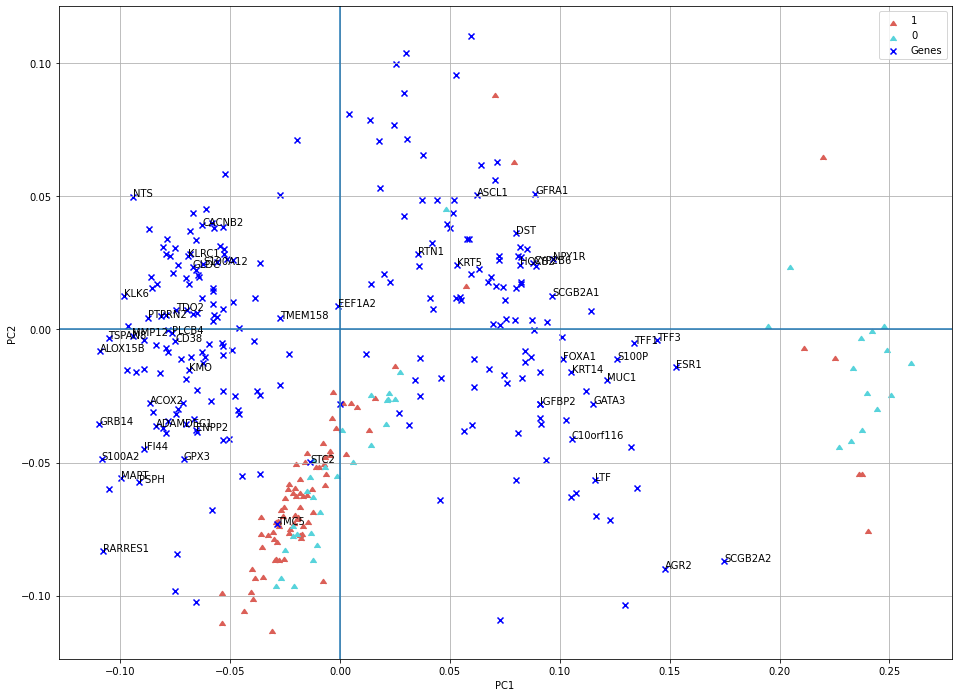

In [48]:
from utils_emb import plot_emb_projection
dist_tx_df = plot_emb_projection(X_tr_diff_9893, y=y_tr_9893, ker="rbf", params={"gamma": 0.003}, annotate=True, annotate_list=feat_diff_exp[:50] ,return_dist=True, label="Genes")

In [52]:
dist_tx_df_out = dist_tx_df.join(st_tamx_df["posOutcome"])
dist_tx_df_out_0 = dist_tx_df_out[dist_tx_df_out["posOutcome"] == 0]
top_50 = list(dist_tx_df_out_0.mean().sort_values(ascending=False).head(50).index)
print_array(top_50)

CPB1
SCGB1D2
STC2
KYNU
GRIA2
TMC5
PCSK1
LTF
PROM1
NDP
TMEM158
TCN1
TFPI2
S100A2
NPY1R
COL14A1
EEF1A2
LRRC17
SCGB2A2
SCGB2A1
ABAT
AGR2
AKR1B10
PTN
DIO1
SERPINA6
UCHL1
KLK11
CXCL14
PTGER3
DKK1
MMP12
SLPI
SERPINA5
FMO5
S100A9
PSPH
SLC1A1
ELF5
SYT1
SOX10
MATN2
PSD3
BIRC5
GRB14
RTN1
VGLL1
KRT5
DNAJC12
RNF128


n_components=(248, 247)


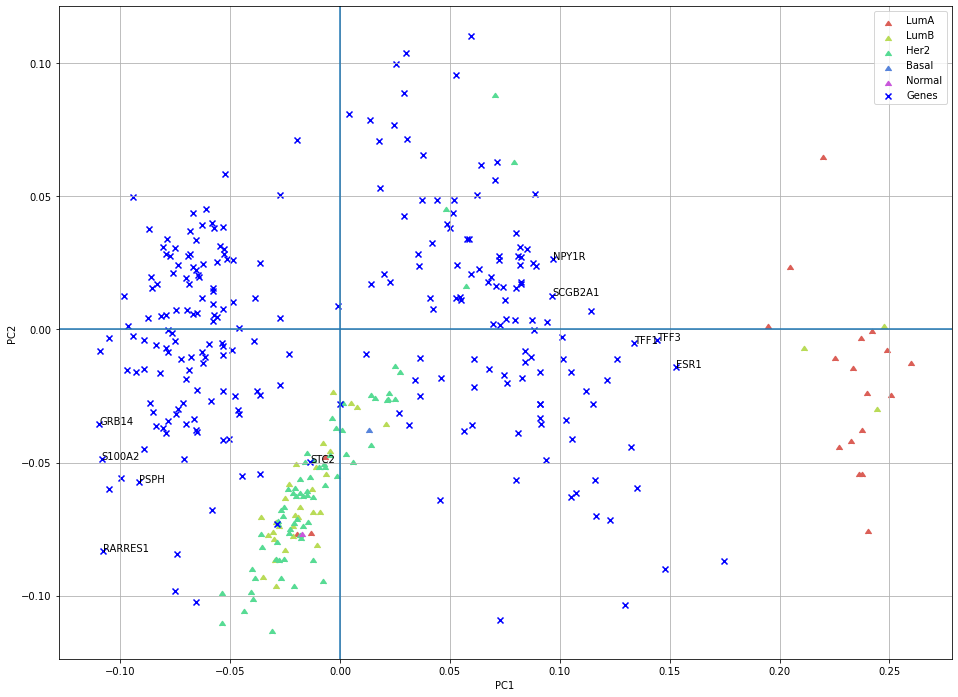

In [38]:
#ESR1 close to LumA
plot_emb_projection(X_tr_diff_9893, y=st_tamx_df["pam_coincide"], target_name="pam_coincide" ,ker="rbf", params={"gamma": 0.003}, annotate=True, annotate_list=feat_diff_exp[:10] ,return_dist=False, label="Genes")

In [8]:

from utils import bmi
feat_scores_df = bmi(X_tr_9893, y_tr_9893, l=0.5)
display(feat_scores_df)

,bmi
MAGEA12,0.000000
MAGEA11,425.134759
KLF1,401.073569
ADH7,0.000000
MSH4,0.000000
...,...
ZSCAN2,136.672736
ZXDC,0.000000
ZYX,446.004190
ZZEF1,307.834342


<AxesSubplot:ylabel='Frequency'>

<Figure size 432x288 with 0 Axes>

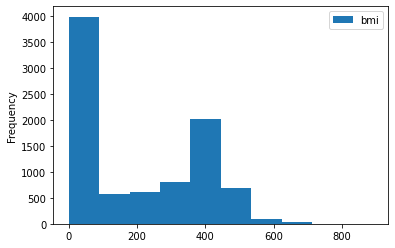

In [9]:
plt.figure()
feat_scores_df.plot.hist()

In [15]:
primary_genes = list(feat_scores_df[feat_scores_df["bmi"] > 550].index)

In [17]:
X_tr_9893[primary_genes]

,METAP1,POLR2J,ITPKC,TMEM158,TWIST1,CD72,NPLOC4,RBX1,LRRC8D,MLYCD,...,THRAP3,TLE4,TNFRSF4,USP2,WISP1,WWP1,XYLT2,YRDC,ZNF576,ZNF673
249608,6.420651,7.201183,5.313337,6.109269,6.189025,6.174342,7.777893,8.644479,8.206177,5.523512,...,4.150371,4.824474,2.851409,3.204984,4.479570,7.188023,4.033188,7.302977,5.935933,4.375840
249599,7.705097,9.172790,6.463636,2.482429,5.429063,2.796687,8.108708,9.681201,7.269816,5.783353,...,3.579878,4.238774,3.139438,3.243106,3.302464,8.169555,4.507480,4.906723,4.367393,4.235622
249560,7.238030,8.481045,5.475539,3.326141,6.609441,4.544341,7.145928,8.520064,7.435109,4.983584,...,3.325677,5.030997,3.633056,2.752673,3.648401,5.997594,4.197470,5.594767,5.019692,5.392732
249627,6.998104,7.092717,5.857596,3.991142,6.935203,3.625783,6.400618,8.672754,8.010418,4.651554,...,3.302348,4.369133,3.829025,3.356792,4.155297,7.021919,4.351857,6.311765,5.378375,6.305916
249695,6.909166,7.665073,5.470799,3.583191,6.538226,4.391956,7.064183,8.305189,8.157117,5.781732,...,2.580556,5.543510,3.557408,2.666897,4.678650,6.229437,5.374809,5.958228,4.612143,4.883358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249644,7.931880,8.504943,5.289933,4.560779,9.101582,5.102281,7.269249,8.982641,9.465130,5.630156,...,2.720030,4.266911,3.442168,3.452523,4.286011,7.232242,4.546414,7.039821,4.740059,6.880613
249658,7.543883,8.279000,5.990804,5.250170,7.586394,4.137313,7.466449,8.604092,8.479874,4.976120,...,3.377976,5.051139,3.509973,4.388033,3.802761,6.452616,4.868732,6.591030,5.627545,6.947446
249605,6.858583,7.082052,5.516379,4.359636,5.566011,4.139123,6.780665,8.734640,8.662918,5.847210,...,3.927542,5.010399,3.352887,3.130058,3.220996,7.181581,6.463552,6.433470,4.877021,4.498022
249639,8.537676,7.539608,5.722523,3.106495,5.845619,4.416014,7.574759,8.961346,8.554224,5.267295,...,3.346158,6.953336,3.757835,3.316822,3.414348,6.933412,4.945646,5.758954,5.201644,6.013656


In [19]:
gamma = optimize_ker_param(X_tr_9893[primary_genes], y_tr_9893.values, "gamma", ker="rbf", r=(0, 0.1))
print(gamma)

((array([0.00513879]),), {})
[-0.27823234]
0.005138786410399554


n_components=(116, 115)


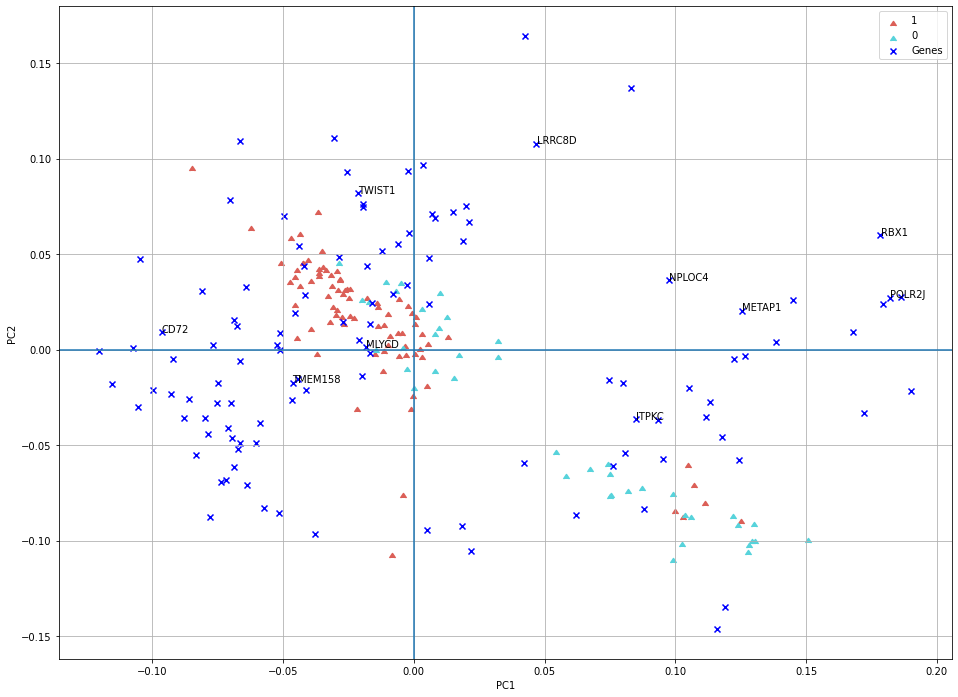

In [39]:
from utils_emb import plot_emb_projection
plot_emb_projection(X_tr_9893[primary_genes], y=y_tr_9893, ker="rbf", params={"gamma": 0.005}, annotate=True, annotate_list=primary_genes[:10] ,return_dist=False, label="Genes")

n_components=(116, 115)


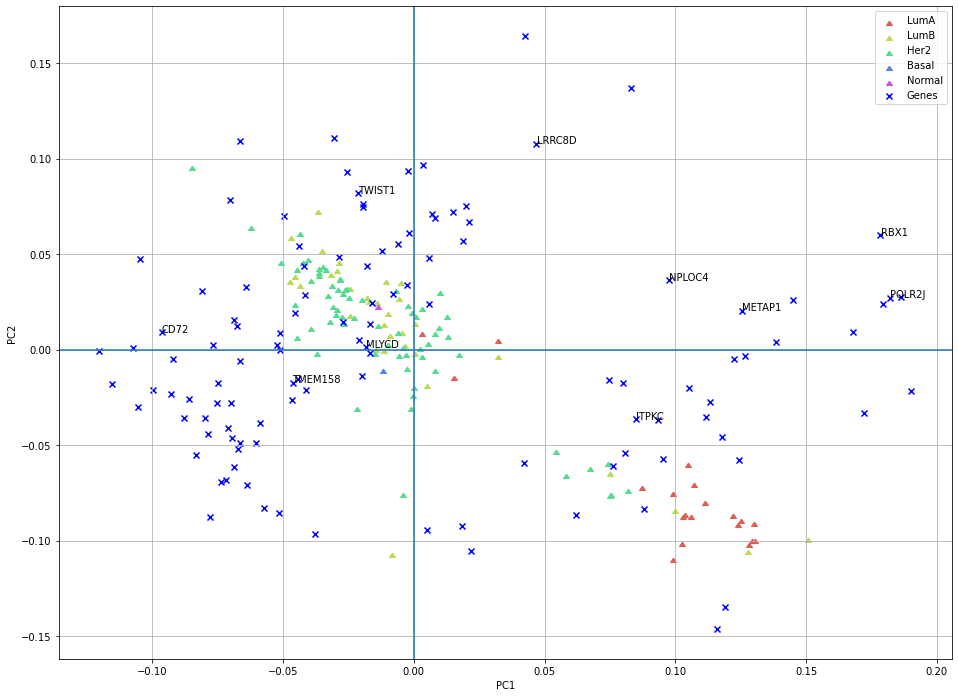

In [40]:
plot_emb_projection(X_tr_9893[primary_genes], y=st_tamx_df["pam_coincide"], target_name="pam_coincide" ,ker="rbf", params={"gamma": 0.005}, annotate=True, annotate_list=primary_genes[:10] ,return_dist=False, label="Genes")